In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

import seaborn as sns
import pandas as pd
from keras.datasets import mnist
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,fe,deep_learning,visual

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [4]:
(x_train, _), (x_test, y_test) = mnist.load_data()

# Add noise

In [5]:
image_size = x_train.shape[1]

In [6]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# generate corrupted image

In [7]:
# generate corrupted MNIST images by adding noise with normal dist
# centered at 0 and std=1
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# clip pixel values

In [8]:
# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)


# Show data

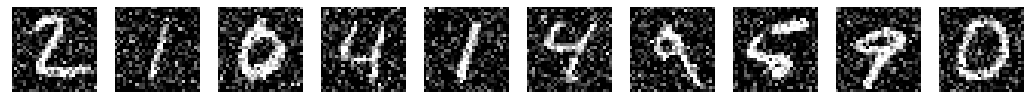

In [9]:
n = 11
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Model

In [10]:
input_shape = (image_size, image_size, 1)

In [13]:
autoencoder,encoded,decoded = deep_learning.denoise_model_1(input_shape,3)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

In [14]:
logfilename = "DenoisingAutoencoder"
batch_size = 32
epochs = 20
tensorboard = TensorBoard(log_dir="logs/{}".format(logfilename),profile_batch = 100000000)

history = autoencoder.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[tensorboard])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 237us/sample - loss: 0.0371 - accuracy: 0.8010 - val_loss: 0.0260 - val_accuracy: 0.8020
Epoch 2/20
60000/60000 [==============================] - 12s 200us/sample - loss: 0.0240 - accuracy: 0.8071 - val_loss: 0.0215 - val_accuracy: 0.8050
Epoch 3/20
60000/60000 [==============================] - 13s 214us/sample - loss: 0.0212 - accuracy: 0.8087 - val_loss: 0.0195 - val_accuracy: 0.8071
Epoch 4/20
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0194 - accuracy: 0.8097 - val_loss: 0.0178 - val_accuracy: 0.8090
Epoch 5/20
60000/60000 [==============================] - 12s 205us/sample - loss: 0.0183 - accuracy: 0.8103 - val_loss: 0.0172 - val_accuracy: 0.8110
Epoch 6/20
60000/60000 [==============================] - 13s 215us/sample - loss: 0.0174 - accuracy: 0.8107 - val_loss: 0.0171 - val_accuracy: 0.8083
Epoch 7/20
60000/60000 [====================

# evaluate

In [15]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 158us/sample - loss: 0.0110 - accuracy: 0.8119
Test loss: 0.010975064240396022
Test accuracy: 0.81189275


# Plot result

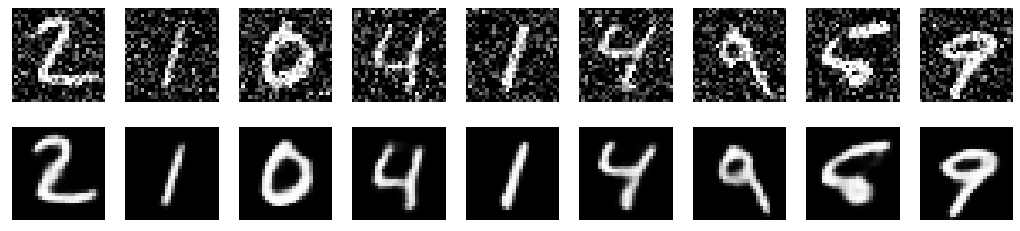

In [18]:
visual.plot_denoise_result(autoencoder,x_test_noisy)

# Model 2

In [20]:
autoencoder = deep_learning.denoise_model_2(input_shape,[32, 64],3,16)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

In [21]:
# train the autoencoder
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 267us/sample - loss: 0.0259 - val_loss: 0.0132
Epoch 2/10
60000/60000 [==============================] - 15s 249us/sample - loss: 0.0123 - val_loss: 0.0115
Epoch 3/10
60000/60000 [==============================] - 16s 263us/sample - loss: 0.0111 - val_loss: 0.0107
Epoch 4/10
60000/60000 [==============================] - 16s 259us/sample - loss: 0.0105 - val_loss: 0.0102
Epoch 5/10
60000/60000 [==============================] - 15s 256us/sample - loss: 0.0101 - val_loss: 0.0100
Epoch 6/10
60000/60000 [==============================] - 16s 270us/sample - loss: 0.0098 - val_loss: 0.0098
Epoch 7/10
60000/60000 [==============================] - 17s 287us/sample - loss: 0.0096 - val_loss: 0.0096
Epoch 8/10
60000/60000 [==============================] - 17s 288us/sample - loss: 0.0094 - val_loss: 0.0095
Epoch 9/10
60000/60000 [==============================] - 18s 307us/sample - l

# evaluate

In [15]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 158us/sample - loss: 0.0110 - accuracy: 0.8119
Test loss: 0.010975064240396022
Test accuracy: 0.81189275


# Plot result

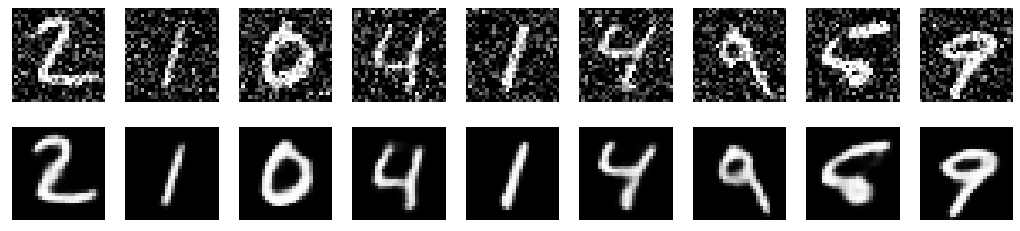

In [18]:
visual.plot_denoise_result(autoencoder,x_test_noisy)